In [1]:
import util
from forward import solve_forward
from simulation import Simulation
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
# to load large .mat files
import mat73
import random
from net import EEG_CNN

2021-12-18 21:36:47.260281: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-18 21:36:47.260310: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### Train the CNN

In [3]:
eeg_topos = mat73.loadmat('/media/thanos/Elements/thanos/sim_data/sim_type_1/eeg_2TeD_topos.mat')['eeg_topos']
eeg_topos = eeg_topos.transpose(2, 0, 1)

Text(0.5, 1.0, 'Topography for eeg signal: 68621')

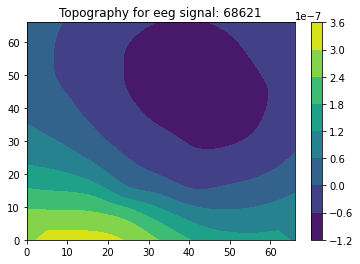

In [4]:
topo_idx = random.randint(0,eeg_topos.shape[0]-1)
topo = eeg_topos[topo_idx,:,:]
plt.contourf(topo, cmap=cm.get_cmap('viridis'))
cbar = plt.colorbar()
plt.draw()
plt.title('Topography for eeg signal: {}'.format(topo_idx+1))

In [5]:
# load previous simulation
sources = np.load('/media/thanos/Elements/thanos/sim_data/sim_type_1/sources_2TeD.npy')
eeg = np.load('/media/thanos/Elements/thanos/sim_data/sim_type_1/eeg_2TeD.npy')
fwd = solve_forward()
sim = Simulation(fwd=fwd, source_data=sources, eeg_data=eeg)
# fwd = solve_forward()
# sim = Simulation(fwd=fwd)
# sim.simulate(n_samples=100)

Forward problem is solved.
Electrodes: (73, 3)
Dipoles: (50460, 3)
Leadfield: (73, 50460)


In [6]:
eegcnn = EEG_CNN(sim=sim, eeg_topographies=eeg_topos)

In [7]:
eegcnn.build_model()

2021-12-18 21:48:50.725350: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-12-18 21:48:50.726351: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-12-18 21:48:50.728133: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (thanos): /proc/driver/nvidia/version does not exist
2021-12-18 21:48:50.749613: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-18 21:48:51.825461: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 69222400 exceeds 10%

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 65, 65, 8)         80        
                                                                 
 batch_normalization (BatchN  (None, 65, 65, 8)        32        
 ormalization)                                                   
                                                                 
 flatten (Flatten)           (None, 33800)             0         
                                                                 
 dense (Dense)               (None, 512)               17306112  
                                                                 
 batch_normalization_1 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 1024)              5

In [8]:
eegcnn.fit(patience=35)

Epoch 1/50
808/808 [==============================] - 1837s 2s/step - loss: 0.0013 - MAPE: 85364576.0000 - val_loss: 0.0011 - val_MAPE: 15930318.0000
Epoch 2/50
808/808 [==============================] - 1450s 2s/step - loss: 4.9840e-04 - MAPE: 36182576.0000 - val_loss: 0.0018 - val_MAPE: 11612504.0000
Epoch 3/50
808/808 [==============================] - 1490s 2s/step - loss: 4.0624e-04 - MAPE: 16357637.0000 - val_loss: 3.9325e-04 - val_MAPE: 3962665.0000
Epoch 4/50
808/808 [==============================] - 1555s 2s/step - loss: 3.8033e-04 - MAPE: 12345189.0000 - val_loss: 3.4065e-04 - val_MAPE: 1753262.7500
Epoch 5/50
808/808 [==============================] - 1494s 2s/step - loss: 3.6585e-04 - MAPE: 10717376.0000 - val_loss: 0.0036 - val_MAPE: 66326736.0000
Epoch 6/50
808/808 [==============================] - 1416s 2s/step - loss: 3.4640e-04 - MAPE: 8488738.0000 - val_loss: 4.1997e-04 - val_MAPE: 409315.3438
Epoch 7/50
808/808 [==============================] - 1410s 2s/step - los

(<keras.callbacks.History at 0x7fe9bd52a700>,
 'logs/CNN-Model-18_12_2021__21:36:49')

In [9]:
#eegcnn.save_nn('/media/thanos/Elements/thanos/nn_trained/cnn_model_4.h5')

eegcnn.save_nn('../cnn_model_2.h5')

### Evaluate the CNN

In [ ]:
eegcnn.load_nn('/media/thanos/Elements/thanos/nn_trained/cnn_model_4.h5')

In [ ]:
eeg_topos_eval = mat73.loadmat('/media/thanos/Elements/thanos/sim_data/sim_type_2/eeg_topographies_type_2.mat')['eeg_topos']
eeg_topos_eval = eeg_topos_eval.transpose(2, 0, 1)

sim_type_2 = util.load_object('/media/thanos/Elements/thanos/sim_data/sim_type_2/sim_obj_10k_type_2.pkl')
sources_eval = sim_type_2.source_data

In [ ]:
mse = eegcnn.evaluate_mse(eeg=eeg_topos_eval,sources=sources_eval)
nmse = eegcnn.evaluate_nmse(eeg=eeg_topos_eval, sources=sources_eval)

print('Normilized MSE:', np.mean(nmse))
print('MSE:', np.mean(mse))